# Social Graphs Explainer Notebook

## 1. Motivation

The dataset chosen for this project consists of characters from the greek mythology.
A [Wikipedia page](https://en.wikipedia.org/wiki/List_of_Greek_mythological_figures) were found, where all major characters from the greek mythology were listed.
Each node represents a character, and there exists an edge from character $i$ to character $j$ if there is a link from the Wikipedia page of character $i$ 
to the Wikipedia page of character $j$.

Greek mythology consists of tales and stories which are very dramatic and contain partnerships, intrigues and large family trees. 
Greek mythology has been used by artists and alike to draw inspiration from throughout time
and even today, Greek mythology is still relevant as it is used for inspiration for many books, movies and games.

Furthermore, the data set is a closed system, which means that no further characters will be added in the future. 
This means that the analysis we are doing will still valid in the future. 

We aim to show the users the connections between characters in the mythology, how communties are formed in the network and if any interesting points can be drawn.
Furthermore, we want the users to be curious and have an interest about greek mythology and such that they want to explore the data themselves. 
This is done by making most plots shown interactive, 
which allows the users to e.g. click on a node to get more information about a character, or filter the network to see the different communities.

## 2. Basic statistics

### 2.1. Data preprocessing

Before proceeding to do the processing of the data set, the process will be described step by step.

Using the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_Greek_mythological_figures) of the list of greek
mythological figures, the page content is downloaded using the Wikipedia API.
There are a lot of characters on this Wikipedia page, but it is not all characters that have their own Wikipedia
page, which it is linked to.
We are only interested in characters with their own page, as the edges between characters are made using the 
Wikipedia page for each character.
To find these characters RegEx was used. 
Five different RegEx expressions were used to find both the characters and the different character types
(God, Deity, Titan, etc.)  as relevant characters or information was surrounded by different symbols in the
Wikipedia text. 

After extracting all relevant characters, a dataframe with three columns consisting of the characters, 
their Wikipedia paths, and the character type, was defined. A total of $777$ characters where found.
 
When inspecting the *character* column in the dataframe, several characters with duplicates were found.
First, all duplicate rows are removed (i.e. rows with the same values in all three columns).
Then, through manual inspection, it is found that some characters have the same name, but are two different people
(e.g. two kings with the same name).
Furthermore, characters with *mythology* or *deity* in their Wikipedia path would be the same character. 
And finally there are characters with the same Wikipedia page, but with different names, as names could be spelled 
two different ways (e.g. Erebos and Erebus). Using this knowledge, the dataframe is cleaned and only relevant
characters are left.

Now, using the final dataframe, the Wikipedia page for all characters are downloaded. Here, both the *raw* text 
(including links, html, etc.) and the clean text (without links, html, etc.) are downloaded.

Using the raw Wikipedia pages, the network is created. The network is initialized as a directed graph.
For each character, all links in their Wikipedia pages are found using RegEx. Then for each link in the dataframe,
it is checked whether the link is in the dataframe. If so, an edge is added to the network from the current
character to the character for which the link refers to.

Finally, the network is plotted. Plotting the entire network, including nodes without any edges, is not very 
informing and can be visually confusing. Thus to make the visualisation better, only the giant connected component 
(GCC) is plotted.
To get the GCC, the graph is made undirected and afterwards the biggest connected component is extracted. 
Afterwards, further visual modifications are made. To see what group a node belongs to (e.g. God, Deity, etc.),
the nodes get assigned a color.
Furthermore, to hightlight which nodes are hubs, the nodes' size depend on their degree.
To get a good layout for the network, the `ForceAtlas2` algorithm is used to calculate the node positions.
The plot is then displayed including a legend to distinguish the different types in the network.

The step by step process with the used code is shown below:

#### 2.1.1. Preprocessing and extracting characters
We start by doing some preprocessing of the data. We start by installing and importing all of the relevant packages:

In [2]:
# Imports:
import urllib
import json
import re
import random
import pandas as pd
import numpy as np
from os import listdir

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
sns.set()

# Network
from community import community_louvain
import community
import networkx as nx
from networkx.readwrite import json_graph
from fa2 import ForceAtlas2

# Language processing

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import FreqDist, WordNetLemmatizer
import nltk

Now we are downloading the stopwords for later usage 

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

As mentioned above, we use the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_Greek_mythological_figures), 
where all major characters from the greek mythology are listed. Though, not all characters in this list has a 
Wikipedia page. So to get all the characters with pages, the page content is downloaded and, using RegEx, all 
characters which has a link/path to another Wikipedia page, are stored. From this, a list of characters were 
created for further investigation.

In [4]:
# Creating the API request URL
base_url = 'https://en.wikipedia.org/w/api.php?'
action = 'action=query'
title = 'titles=List_of_Greek_mythological_figures'
content = 'prop=revisions&rvprop=content'
data_format = 'format=json'

# Creating the query
query = f'{base_url}&{action}&{title}&{content}&{data_format}'
wiki_source = urllib.request.urlopen(query)
wiki_data = wiki_source.read()
wiki_json = json.loads(wiki_data)

# Get the data
page_num = list(wiki_json['query']['pages'].keys())[0]
wiki_text = wiki_json['query']['pages'][page_num]['revisions'][0]['*']

We use RegEx to filter through all the links that might be in the text and find the different characters there
exist within the text.

In [5]:
## Wise words of the day
# You have a problem
# The solution is regex
# You now have two problems

# Create regex to find all relevent info from the wiki text
first_filter = re.findall(r"\*(.*?)\[\[(.*?)\]\](.*?)\n" + "|"
                          + "\'\'\' \[\[(.*?)\]\]\'\'\'" + "|"
                          + "\'\'\'\[\[(.*?)\]\]\'\'\'" + "|"
                          + "\|\| \[\[(.*?)\]\] \|\|" + "|"
                          + "\=\=(.*?)\=\=", 
                          wiki_text)

# Create a data dictionary to create a dataframe from
data = {'character': [],
        'wikilink': [],
        'feature': []}

# Create some sort of distinction between characters - Defining types/features.
types = ['gods', 'primordial deities', 'titans', 'giants', 
         'personified concepts', 'deities', 'mortals']

# Define a current type/feature (type is already a function in python, so the variable name feature is used)
feature = ''

# Go through all the things the regex found 
for link in first_filter[:-10]:
    
    # For the sixth index, we have the different types/features indicated
    if link[6] != '':
        for t in types:
            if t in link[6].lower():
                # Some of the deities are mentioned as gods, so the feature changes back and forth between gods and deities, 
                # which is not desired.
                if feature == 'deities' and t == 'gods':  
                    break
                feature = t
                break
        continue
    

    # Some of the other indexes indicate characters
    if link[1] != '':
        character = link[1].split('|')
        if len(character) == 1:
            data['character'].append(character[0])
            data['wikilink'].append(character[0].replace(' ', '_'))
            data['feature'].append(feature)
        else:
            data['character'].append(character[1])
            data['wikilink'].append(character[0].replace(' ', '_'))
            data['feature'].append(feature)
    
    elif link[3] != '':
        character = link[3].split('|')
        if len(character) == 1:
            data['character'].append(character[0])
            data['wikilink'].append(character[0].replace(' ', '_'))
            data['feature'].append(feature)
        else:
            data['character'].append(character[1])
            data['wikilink'].append(character[0].replace(' ', '_'))
            data['feature'].append(feature)
    
    elif link[4] != '':
        character = link[4].split('|')
        if len(character) == 1:
            data['character'].append(character[0])
            data['wikilink'].append(character[0].replace(' ', '_'))
            data['feature'].append(feature)
        else:
            data['character'].append(character[1])
            data['wikilink'].append(character[0].replace(' ', '_'))
            data['feature'].append(feature)
    
    elif link[5] != '':
        character = link[5].split('|')
        if len(character) == 1:
            data['character'].append(character[0])
            data['wikilink'].append(character[0].replace(' ', '_'))
            data['feature'].append(feature)
        else:
            data['character'].append(character[1])
            data['wikilink'].append(character[0].replace(' ', '_'))
            data['feature'].append(feature)

Now we create a dataframe for the data. We make sure that each type of character is found in the text and search
for any duplicate characters, with either the same row or the same character name.

In [6]:
# Create dataframe
df = pd.DataFrame(data)
df

,character,wikilink,feature
0,Aphrodite,Aphrodite,gods
1,Apollo,Apollo,gods
2,Ares,Ares,gods
3,Artemis,Artemis,gods
4,Athena,Athena,gods
...,...,...,...
772,Danaides,Daughters_of_Danaus,mortals
773,Ixion,Ixion,mortals
774,Sisyphus,Sisyphus,mortals
775,Tantalus,Tantalus,mortals


In [7]:
# Check if all unique types is present
df['feature'].unique()

array(['gods', 'primordial deities', 'titans', 'giants',
       'personified concepts', 'deities', 'mortals'], dtype=object)

In [8]:
# Show duplicate characters
df[df.duplicated(subset=['character'])]

,character,wikilink,feature
65,Pallas,Pallas_(Giant),giants
78,Cyclopes,Cyclopes,giants
88,Achlys,Achlys,personified concepts
128,Eros,Eros_(god),personified concepts
151,Hypnos,Hypnos,personified concepts
...,...,...,...
755,Asteria,Asteria_(mythology)#Amazon,mortals
757,Celaeno,Celaeno,mortals
767,Orithyia,Orithyia_(Amazon),mortals
773,Ixion,Ixion,mortals


We remove all duplicated rows to see how the duplicate list look now.

In [9]:
# Try to remove duplicated rows
df = df.drop_duplicates().reset_index(drop=True)
df[df.duplicated(subset=['character'])]

,character,wikilink,feature
65,Pallas,Pallas_(Giant),giants
87,Achlys,Achlys,personified concepts
127,Eros,Eros_(god),personified concepts
150,Hypnos,Hypnos,personified concepts
171,Nemesis,Nemesis_(mythology),personified concepts
202,Thanatos,Thanatos,personified concepts
210,Cronus,Cronus,deities
227,Nyx,Nyx_(mythology),deities
228,Hades,Hades_(mythology),deities
234,Lethe,Lethe,deities


In the duplicate list, we notice that that characters could have the same name but differed in the link.
Thus it was actually two different characters. Characters with *mythology* or *deity* in its Wikipedia link are 
often the same character. Thus if they have these two key words in their wiki link, they are removed.

Additionally, there are some characters that have to be removed manunally.

In [10]:
# Going through the duplicate list.
# Create new character names for characters with different wiki links.
# If the wiki link include 'mythology' or 'deity', its a copy-
for c in df[df.duplicated(subset=['character'])]['character'].values:
    index = df[df['character'] == c].index
    condition1 = ('mythology' not in df.loc[index[0], 'wikilink'] and 'deity' not in df.loc[index[0], 'wikilink'])
    condition2 = ('mythology' not in df.loc[index[1], 'wikilink'] and 'deity' not in df.loc[index[1], 'wikilink'])
    if condition1 and condition2:
        df.loc[index[0], 'character'] = df.loc[index[0], 'wikilink'].replace('_', ' ')
        df.loc[index[1], 'character'] = df.loc[index[1], 'wikilink'].replace('_', ' ')

In [11]:
# Manually remove these characters because of small name changes of irrelevancy (e.g. Pontos is also spelled Pontus)
remove = ['Giants (Greek mythology)#Named Giants', 'Erebos', 'Pontos', 'Korybantes', 'Menoetes']
df = df[~df['character'].isin(remove)]

In [12]:
# Check if it worked
df.loc[index[0], 'character']

'Orithyia (Athenian)'

In [13]:
# Check the duplicate list
df[df.duplicated(subset=['character'])]

,character,wikilink,feature
87,Achlys,Achlys,personified concepts
150,Hypnos,Hypnos,personified concepts
171,Nemesis,Nemesis_(mythology),personified concepts
202,Thanatos,Thanatos,personified concepts
210,Cronus,Cronus,deities
227,Nyx,Nyx_(mythology),deities
228,Hades,Hades_(mythology),deities
234,Lethe,Lethe,deities
236,Styx,Styx,deities
237,Tartarus,Tartarus,deities


In [14]:
# Remove the remaining duplicate characters. 
df = df[~df.duplicated(subset=['character'])].reset_index(drop=True)

Now we prepare the *wikilink* column, such that it is possible to download the pages for all the characters.

In [15]:
# Decode the strings to only include chars the Wiki API can read (e.g. changing ë to e)
df['wikilink'] = df['wikilink'].str.normalize('NFKD')\
                               .str.encode('ascii', errors='ignore')\
                               .str.decode('utf-8')

# Remove hashtags and the words appearing after it, so the API can read the link
df['wikilink'] = df['wikilink'].str.replace('\#.*', '')

Save the dataframe as a CSV-file for future use.

In [16]:
# Save the dataframe
df.to_csv('GreekMythologyNetwork/greek_characters.csv')

#### 2.1.2. Download pages for all characters

The dataframe is loaded, and we check the number of characters.

In [17]:
# Load csv to dataframe and see length of unique characters.
df = pd.read_csv('GreekMythologyNetwork/greek_characters.csv', index_col=0)
len(df['character'].unique())

689

A function is created that makes it possible to download the Wikipedia pages for all characters. 
The function is able to both get the 'raw' pages (with links, etc.) and 'clean' pages (without links, etc.).

In [18]:
def download_wiki():
    for index, row in df.iterrows():
        character = row['character']
        link = row['wikilink']
        
        if '/' in character:
            character = character.replace('/', '_')
        
        base_url = 'https://en.wikipedia.org/w/api.php?'
        action = 'action=query'
        title = 'titles=' + link
        content = 'prop=extracts&exlimit=max&explaintext'  # To get text without links, etc. (clean)
        #content = 'prop=revisions&rvprop=content'  # To get text with links, etc. (raw)
        data_format = 'format=json'
        
        try:
            query = f'{base_url}&{action}&{title}&{content}&{data_format}'
            wiki_source = urllib.request.urlopen(query)
            wiki_data = wiki_source.read()
            wiki_json = json.loads(wiki_data)

            page_num = list(wiki_json['query']['pages'].keys())[0]
            wiki_text = wiki_json['query']['pages'][page_num]['extract']  # to get text without links (clean)
            #wiki_text = wiki_json['query']['pages'][page_num]['revisions'][0]['*'] # to get text with links (raw)

            text_file = open(f'project/wikipages/clean/{character}.txt', 'w', encoding="utf-8")
            text_file.write(wiki_text)
            text_file.close()

        except:
            print(character, link)


#### 2.1.3. Creating nodes, edges, and attributes

In [19]:
# Capitalize the feature column and check if it is done correctly
df['feature'] = df['feature'].str.capitalize()
df['feature'].unique()

array(['Gods', 'Primordial deities', 'Titans', 'Giants',
       'Personified concepts', 'Deities', 'Mortals'], dtype=object)

Now, the network is created by finding all the edges between the characters.
This is done by going through all the downloaded Wikipedia pages and finding all the links in them.
The links are then checked to exist in the characters dataframe. 
If a link is found in the dataframe, an edge between the character (which the wiki page belonged to) and the character from the link is created. 
Creating the edges also creates the nodes for the network.
If a character has no links to other characters from the list, a single node is created.

In [20]:
# Create a directed graph
G = nx.DiGraph()

# There is a character with a frontslash in its name.
# This is changed to avoid confusing it with a directory.
df.loc[df['character'] == 'Thoas/Thoon', 'character'] = 'Thoas_Thoon'
greek_character = df['character'].values

# Go through all characters in the dataframe
path = 'GreekMythologyNetwork/wikipages/raw'
for gc in greek_character:
    data = open(path + '/' + gc + '.txt', 'r', encoding="utf-8")  # Open the text
    text = data.read()  # and read it
    links = re.findall(r'\[\[(.+?)\]\]', text)  # Find all the links in the text
    edges = []  # Define a list for the edges.
    
    # Make sure only to get greek character and not the link
    for l in links:
        character = l.split('|')
        if len(character) == 1:
            if character in greek_character:
                edges.append(character[0])
        else:
            if character[1] in greek_character:
                edges.append(character[1])

    data.close()
    
    # Append the edges between greek characters to the list
    # If the character has no links to other characters, add a node.
    if edges:
        edges = [(gc, e) for e in edges]
        G.add_edges_from(edges)
    else:
        G.add_node(gc)

The attributes are added using the feature column and character column from the dataframe.

In [21]:
## Adding attribute(s)
# Create a dictionary for relevant attribute
attribute_dict = pd.Series(df.feature.values,index=df.character).to_dict()
# Add them to the network
nx.set_node_attributes(G, attribute_dict, 'type')

# Testing it
G.nodes['Galene']

{'type': 'Deities'}

And the network is saved as a json, for future use.

In [22]:
# Save the graph as a json file
path = 'GreekMythologyNetwork/graphs/'
with open(path + 'directed_graph.json', 'w', encoding='utf-8') as f:
    data = json_graph.adjacency_data(G)
    json.dump(data, f, ensure_ascii=False, indent=4)

As explained earlier, we extract the GCC in order to get a plot that is more visually appealing:

In [23]:
# Get the giant connected component
G_UD = G.to_undirected()
print(f'The size of the whole network is {len(G_UD.nodes())}')
Gcc_nodes = max(nx.connected_components(G_UD), key=len)
Gcc = G_UD.subgraph(Gcc_nodes)
print(f'The size of the GCC is {len(Gcc_nodes)}')

The size of the whole network is 689
The size of the GCC is 648


To get a good layout for the network, the `ForceAtlas2` algorithm is used to calculate the node positions. 
These positions are then stored as a JSON file for later use.

In [24]:
## Define the ForceAtlas2 algorithm and create positions for the network
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(Gcc, pos=None, iterations=2000)

100%|██████████| 2000/2000 [00:08<00:00, 223.69it/s]BarnesHut Approximation  took  2.49  seconds
Repulsion forces  took  5.70  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.25  seconds



In [25]:
positions_data = open('GreekMythologyNetwork/graphs/positions.json', 'r')
positions = json.load(positions_data)
positions_data.close()

Now the network is plotted. The undirected graph of the network is plotted, to reduce the amount
of edges displayed.
A color map is defined to make it possbile to distinguish between the different groups of characters (Gods, Deities, etc.).
Furthermore, a size factor is defined to indicate which characters are characters that are hubs.
A custom legend is used, to show what each color belongs to.

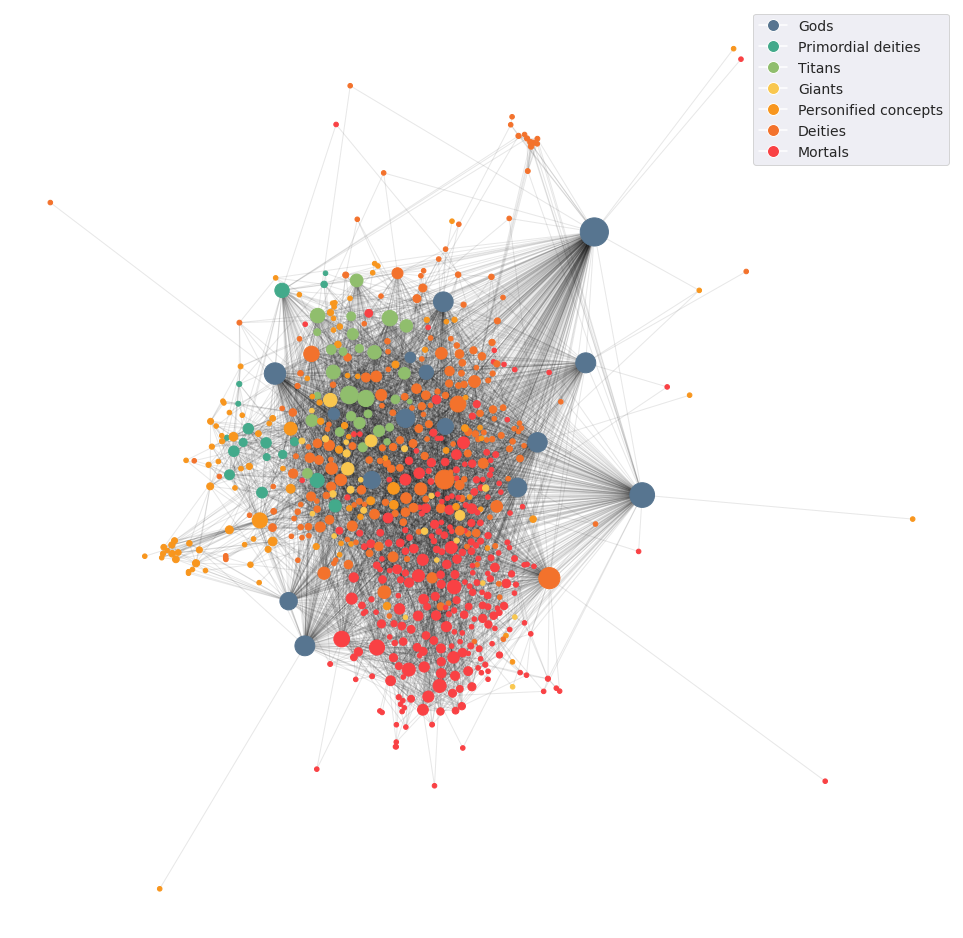

In [26]:
# Create color map and size factor.
colors = ['#577590', '#43aa8b', '#90be6d', '#f9c74f', '#f8961e', '#f3722c', '#f94144']
color_map = dict(zip(df['feature'].unique(), colors))
size_factor = 3

# Get all degrees and make the smallest nodes a certain size.
degrees = np.array([d[1] for d in Gcc.degree()])
degrees[degrees < 7] = 7

plt.figure(figsize=(17, 17))

# Create the custom legends.
legend_elements = [Line2D([0], [0], 
                          color='w', 
                          marker='o',
                          markerfacecolor=value,
                          markersize=12,
                          label=key) 
                   for key, value in color_map.items()]

# Plot the nodes.
nx.draw_networkx_nodes(Gcc, 
                       positions, 
                       node_size=degrees*size_factor,
                       node_color=[color_map[n[1]] for n in Gcc.nodes(data='type')],
                       alpha=1)

# Plot the legends.
nx.draw_networkx_edges(Gcc, 
                       positions, 
                       alpha=0.1)


plt.legend(handles=legend_elements, prop={'size': 14})
plt.axis('off')
plt.savefig('network.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

### 2.2. Basic statistics

As the graph is now defined, we find the number of nodes and edges within it:

In [27]:
# Find number of nodes and edges
n = G.number_of_nodes()
e = G.number_of_edges()

print(f'The network contains {n} nodes and {e} edges.')

The network contains 689 nodes and 7202 edges.


We then find the in- and out-degree distributions for the network. First all the isolate nodes are removed from the 
network. And then numpy is used to create a histogram of the degree distributions.

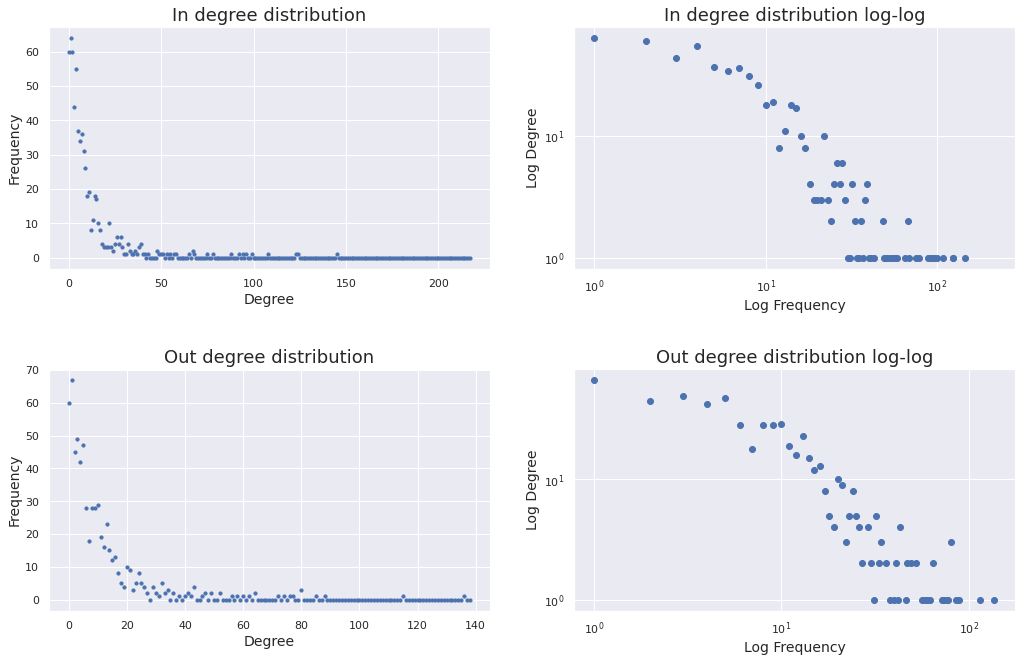

In [28]:
## Remove all the isolates
G_isolates = G.copy()
isolates = list(nx.isolates(G))
G_isolates.remove_nodes_from(isolates)

## In-degree
in_degree = np.array([d[1] for d in G_isolates.in_degree()])

## Out-degree
out_degree = np.array([d[1] for d in G_isolates.out_degree()])

# Creating the plot, using a 3 row, 2 column subplot
fig, ax = plt.subplots(2, 2, figsize=(15,10))

degree = [in_degree, out_degree]
titles = ['In degree distribution',  'Out degree distribution']

for i in range(2):
    min_degree = min(degree[i])
    max_degree = max(degree[i])

    v = np.arange(min_degree, max_degree)
    hist, bin_edges = np.histogram(degree[i], bins=v)
    bins = bin_edges[:-1]

    ax[i, 0].scatter(bins, hist, s=10)
    ax[i, 0].set_xlabel('Degree', size=14)
    ax[i, 0].set_ylabel('Frequency', size=14)
    ax[i, 0].set_title(titles[i], size=18)
    ax[i, 1].loglog(bins, hist, 'o')
    ax[i, 1].set_xlabel('Log Frequency', size=14)
    ax[i, 1].set_ylabel('Log Degree', size=14)
    ax[i, 1].set_title(titles[i] + ' log-log', size=18)

fig.tight_layout(pad=3.0)
plt.show()


It is seen that both the in- and out-degree distributions follow a Power Law. 
There are many nodes with low in- and out-degrees, where a few of the nodes have high degrees. 
These are classified as hubs, and the presence of these are expected from our knowledge of greek mythology. 
We would expect these to be some of the Gods that appear frequently throughout the mythological stories.

We now find the top 10 characters in terms of having highest in- and out-degrees:

In [29]:
# Top 10 nodes in terms of in-degree
sorted(G.in_degree, key=lambda x: x[1], reverse=True)[:10]

[('Zeus', 219),
 ('Apollo', 145),
 ('Poseidon', 124),
 ('Heracles', 123),
 ('Dionysus', 108),
 ('Athena', 99),
 ('Aphrodite', 96),
 ('Hera', 94),
 ('Artemis', 92),
 ('Hermes', 88)]

In [30]:
# Top 10 nodes in terms of out-degree
sorted(G.out_degree, key=lambda x: x[1], reverse=True)[:10]

[('Apollo', 140),
 ('Zeus', 136),
 ('Naiad', 115),
 ('Poseidon', 88),
 ('Oceanus', 85),
 ('Dionysus', 80),
 ('Athena', 80),
 ('Heracles', 80),
 ('Hermes', 77),
 ('Aphrodite', 76)]

When examining the top 10 characters with highest in- and out-degree, it is seen that the gods make up large parts 
of both lists. For the in-degree all characters are gods, except for *Heracles*, while for the out-degree, 
there is both a Deity (*Naiad*) and a Titan (*Oceanus*) which are hubs.

## 3. Tools, theory and analysis. Describe the process of theory to insight

### 3.1. Explanation of the overall idea

The overall idea of our analysis is to give the user some interesting knowledge of the network. This is done using
some of the tools from the course. We will do some analysis on both the graph and the individual Wikipedia text.
Our main goals and problem statements include:
- Finding the communities using the Louvain algorithm
    - Do the communities make sense?
    - What is the modularity? How does it compare to communities based on their categories (Gods, titans, ...)?
- WordClouds using TF-IDF
    - Analyze the WordClouds for each community. Are we able to characterize the communities by specific topics?
- Sentiment Scores
    - Calculate the sentiment scores, finding the happiest and saddest characters.
    - Calculate the sentiment scores for each community.

This leads up to the overall discussion that is carried out at the end.

### 3.2. Communities

We are interested in finding the communities in the graph. In order to do this, we use the
[Louvain algorithm](https://perso.crans.org/aynaud/communities/), which is a method that is used to find
communities efficiently, while optimizing the modularity. It is non-deterministic, thus it yields a different
output every time we run it. To avoid this, we set the `random_state` (seed) such that we get the same output
for each time.

In [31]:
# Find communities using Louvain algorithm
partition = community_louvain.best_partition(Gcc, random_state=123)

# Save the partition
with open('community.json', 'w', encoding='utf-8') as outfile:
    json.dump(partition, outfile, indent=4)

We create a dictionary for storing the communities. In the dictionary, the community number (the assigned index
from the Louvain algorithm) is the key, and for each key is assigned a value, being a list of the characters
there exist within the community. We print out the characters to explore whether we can see any tendency in each
community assignment:

In [32]:
# Create a dictionary with community number as key and list of characters within the community as value
community = {}

for key, val in partition.items():
    if val not in community.keys():
        community[val] = [key]
    else:
        community[val].append(key)

for key, val in community.items():
    print('Community ' + str(key))
    print(val)
    print()

Community 0
['Aphrodite', 'Hephaestus', 'Ares', 'Hermes', 'Adonis', 'Aeacus', 'Angelos', 'Artemis', 'Eileithyia', 'Enyo', 'Ersa', 'Hebe', 'Pandia', 'Persephone', 'Horae', 'Litae', 'Eros', 'Phobos', 'Deimos', 'Harmonia', 'Pothos', 'Anteros', 'Himeros', 'Peitho', 'Hera', 'Aglaea', 'Charites', 'Dike', 'Pandora', 'Psyche', 'Aloadae', 'Phlegyas', 'Chione', 'Demeter', 'Erotes', 'Kydoimos', 'Enyalius', 'Aura', 'Lelantos', 'Despoina', 'Plutus', 'Philomelus', 'Atë', 'Pasithea', 'Eucleia', 'Eupheme', 'Philophrosyne', 'Cabeiri', 'Euthenia', 'Cacus', 'Iris', 'Echo', 'Ixion', 'Angelia', 'Oread', 'Tyche', 'Roma', 'Sithon', 'Auxo', 'Euporie', 'Orthosie', 'Lyssa', 'Hedone', 'Poros', 'Adephagia', 'Amechania', 'Penia', 'Ptocheia', 'Dyssebeia', 'Eusebeia', 'Eros (god)', 'Hedylogos', 'Nomos', 'Iynx', 'Thrasos', 'Antheia', 'Amphictyonis', 'Anthousai', 'Alexiares and Anicetus', 'Hegemone', 'Auxesia', 'Karpo']

Community 1
['Poseidon', 'Perseus', 'Nereid', 'Iamus', 'Idmon', 'Branchus', 'Peneus', 'Agenor', 'D

We get 10 communities, indexed from 0 to 9. From the above output, it is seen that some of the communities have many characters, and some of them being
rather unknown. We thus start by taking a look at how many characters there are within each community:

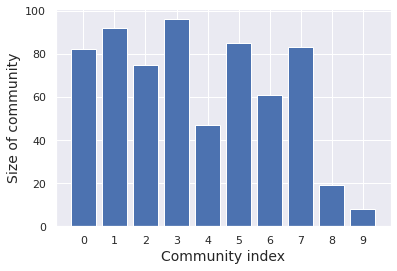

In [33]:
# Find the size of each community
com_size = [len(community[key]) for key in community.keys()]

# Plot the distribution of community sizes
plt.bar(community.keys(), com_size)
plt.xlabel('Community index', size=14)
plt.xticks(range(10))
plt.ylabel('Size of community', size=14)
plt.show()

It is seen that most of our communities are large, as most communities have over 60 characters. Community 9 has
the smallest number of characters.

As mentioned earlier, from the list of characters within each community, there are many characters, 
we do not know, so we could take a look at the five most connected characters for each community, 
to find out whether they make sense:

In [34]:
# Find top 5 monst connected characters within each community:
community_top5 = {}
for c in community:
    G_com = G.subgraph(community[c])
    most_connected = sorted(dict(G_com.degree()).items(), key = lambda x : x[1], reverse=True)
    most_connected = [x[0] for x in most_connected[:5]]
    community_top5[c] = most_connected
    print("Community", c)
    print(most_connected)

Community 0
['Aphrodite', 'Ares', 'Hermes', 'Hephaestus', 'Hera']
Community 1
['Poseidon', 'Naiad', 'Nereus', 'Nereid', 'Ceto']
Community 2
['Dionysus', 'Asclepius', 'Oedipus', 'Tiresias', 'Creon']
Community 3
['Apollo', 'Achilles', 'Agamemnon', 'Odysseus', 'Athena']
Community 4
['Zeus', 'Euterpe', 'Mese', 'Nete', 'Melpomene']
Community 5
['Oceanus', 'Uranus', 'Tethys', 'Cronus', 'Hades']
Community 6
['Eris', 'Erebus', 'Hypnos', 'Thanatos', 'Aether']
Community 7
['Heracles', 'Theseus', 'Minos', 'Jason', 'Medea']
Community 8
['Erichthonius', 'Pandion I', 'Eleusis', 'Cecrops', 'Erechtheus']
Community 9
['Soter', 'Soteria', 'Homonoia', 'Arete', 'Eupraxia']


We are starting to make more sense of the communities. From our knowledge, the first community consists of Gods.
Aphrodite, Ares, Hermes, Hephaestus and Artemis are siblings, which could be one of the resons why these 
characters are within one community. The five most connected characters of community 1 are all water deities,
i.e. we can suppose that community 1 is related to water. The last community (community 9) also makes sense, as
Soter is related to the four other characters, by being their father or husband. Thus the communities detected by the
Louvain algorithm make sense as the characters in each community have similar traits such as being in the same
family or having same abilities.

We now compute how well the community detection was. This is done by finding the modularity of the communities:


In [35]:
# Find modularity of detected communities
community_partition = [community[i] for i in community.keys()]
nx.algorithms.community.quality.modularity(Gcc, community_partition)

0.33812660007116097

For the detected communities, we get a modularity score of $0.338$. As the modularity score is in a range between
-1 and 1, this is not a very high score, but it is still in the positive end. This could be due to how Greek
mythology does not have any obvious partition, from our knowledge. There are no clear subgroups (as also seen
from our community detection). One way to partition our graph is to look at the types, i.e. the graph attributes.
We compute the modularity of this partition:

In [36]:
# Find modularity of types communities
attr_dict = {i: attribute_dict[i] for i in list(Gcc_nodes)}
attr_community = {}

for key, val in attr_dict.items():
    if val not in attr_community.keys():
        attr_community[val] = [key]
    else:
        attr_community[val].append(key)

attr_community_partition = [attr_community[i] for i in attr_community.keys()]

nx.algorithms.community.quality.modularity(Gcc, attr_community_partition)

0.18695838333599168

From the above output, it is seen that we get a lower modularity score than before. This indicates that the
characters within each type also interacts a lot with characters with other types.

One goal of our communities is also to create WordClouds, thus we prepare for doing so. This is done using the
TF-IDF score of the words there are within each character's page in the communities. We start out by extracting
the clean text from our Wikipedia pages and tokenizing. The tokens are stored in a dictionary, where each
community is a key and the tokens are stored as values.

In [37]:
# Get all the words from the files, lowercase, and tokenize them.
# The words are stored in the word dictionary.
words = {}

for key, val in partition.items():
    try:
        name = key
        raw = open('GreekMythologyNetwork/wikipages/clean/' + name + '.txt', 'r', encoding="utf-8")
    except:
        continue
    
    text = raw.read()
    text = text.lower()
    tokens = re.findall(r'\w+', text)
    if val not in words.keys():
        words[val] = tokens
    else:
        words[val] += tokens 
    
    raw.close()

For our Term Frequency (TF), we use the raw count. This is found using the `FreqDist()` method:

In [38]:
# Create a dictionary to store the FreqDist for each community
com_freq = {}

# Go through all community
for key in words.keys():
    com_words = words[key]
    # First, we start by removing stop words
    stop_words = stopwords.words('english')
    com_words = [w for w in com_words if not w in stop_words] 

    # Lemmatize the words
    wnl = WordNetLemmatizer()
    com_words = [wnl.lemmatize(w) for w in com_words]

    # Create FreqDist
    com_freq[key] = FreqDist(com_words)

Now, we calculate the Inverse Document Frequency (IDF). We use the Inverse Document Frequency weighting scheme,
which is defined as:

$$\log\left(\frac{N}{n_t}\right) = -\log\left(\frac{n_t}{N}\right)$$

where $N$ is the total number of documents in the corpus and $n_t$ is the number of documents that the term $t$ 
appears in. In our case, the documents are the lists of tokens in each community and the number of documents is 
the number of communities:

In [39]:
# Using inverse document frequency (-log(n_t/N))

# Create a dictionary to count number of documents a word appear in
nt = {}
N = len(words.keys())

# Find n_t (Number of docs where t appears)
for key in com_freq.keys():
    for word in com_freq[key]:
        if word not in nt.keys():
            nt[word] = 1
        else:
            nt[word] += 1

keys = list(nt.keys())
idf = np.log(N/np.array(list(nt.values())))

# Create dictionary with idf's
idfs = dict(zip(keys, idf))

Now that we have both the TF and the IDF, we are able to calculate the combined TF-IDF for each community:

In [40]:
from collections import Counter

# Store them in a dictionary
tfidf = {}

# Go through all communities
for key in com_freq.keys():
    tfidf[key] = {}  # Create a dictionary to store the words for each community
    for word, count in com_freq[key].items():
        tfidf[key][word] = count*idfs[word]

# Store them as a file
with open('tfidf.json', 'w', encoding='utf-8') as outfile:
    json.dump(tfidf, outfile, indent=4)

We are now able to examine the TF-IDF scores for the words belonging to each community. As there are many words
that have an assigned score, we look at the 10 words with the highest scores for each of the communities:

In [41]:
# For each community, print the top 10 characters with highest TF-IDF scores:
for key in tfidf.keys():
    print(f'Community {key}')
    d = Counter(tfidf[key])
    print(d.most_common(10))
    print()

Community 0
[('aura', 110.5240844637142), ('pandora', 101.70827123803122), ('aphrodite', 94.16657865459652), ('adonis', 81.09822012551359), ('despoina', 80.47189562170502), ('peitho', 62.30776976744255), ('hebe', 58.23412110932294), ('horae', 54.9774439124493), ('narcissus', 49.36288497736338), ('rom', 49.213449819756114)]

Community 1
[('andromeda', 264.7972856943153), ('proteus', 72.23836825955617), ('triton', 69.90828901199154), ('galatea', 55.38274899899306), ('inachus', 52.97480339034119), ('polyphemus', 50.060911129067094), ('aegyptus', 45.06426154815481), ('amphitrite', 42.14937366621113), ('danau', 38.484210738714516), ('argus', 38.484210738714516)]

Community 2
[('creon', 162.55322915584412), ('midas', 159.33435333097592), ('jocasta', 133.54993539365466), ('antigone', 131.94586538987835), ('oedipus', 125.66310344643372), ('attis', 110.76549799798612), ('priapus', 107.83234013308471), ('laius', 96.56627474604602), ('polynices', 94.95683683361192), ('silenus', 92.70590593309709)

We have to link the above output to our knowledge about each community. To recap it shortly, we know that the 
first community (community 0) mainly consisted of Gods with Aphrodite, Ares and Hermes being some of the most
connected characters. Thus it makes sense that some of the words with highest TF-IDF scores are *aura*, *pandora*
and other Gods' names. This is a general theme that goes through the characters with high TF-IDF scores, e.g. in
community 1, the words with high scores are names of Gods that are related to the water.

### 3.3. WordClouds

First of all we want to create a function to give our wordclouds an appropriate color. We have decided to use blue:

In [42]:
# Define functions to recolor the wordcloud in blue
def blue_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(218, 100%%, %d%%)" % random.randint(15, 50)

We want to create a WordCloud for each community and their respective TF-IDF dictionary. 
To do this, a function called `plot_wordcloud()` is created:

In [43]:
# Create function to plot the wordcloud:
def plot_wordcloud(tf_tr_dict, color_func=None, community=None):
    tokens = []
    for item in tf_tr_dict.items():
        tokens += [item[0]]*int(item[1])
    string = ' '.join(tokens)

    wordcloud = WordCloud(background_color='white',
                          width=1800,
                          height=1400,
                          collocations=False).generate(string)

    if color_func:
        wordcloud.recolor(color_func=color_func, random_state=1)
    
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    if community:
        plt.savefig('wordclouds/community' + str(community) + '_wordcloud.png')
    plt.show()

Now, using a loop and the `plot_wordcloud()` function, we plot the wordclouds for each community:

WordCloud for the 0 community


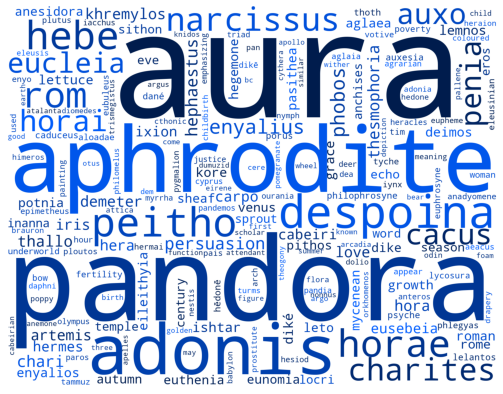


WordCloud for the 1 community


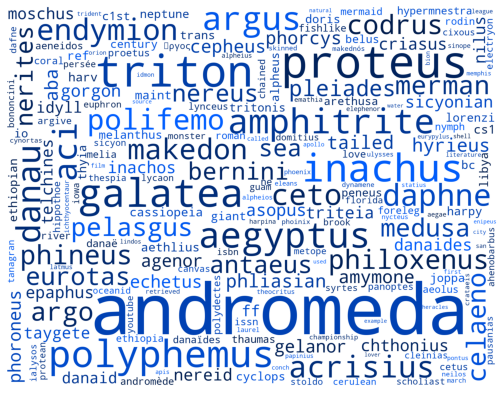


WordCloud for the 2 community


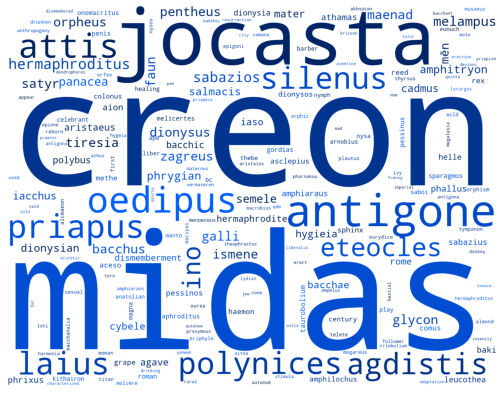


WordCloud for the 3 community


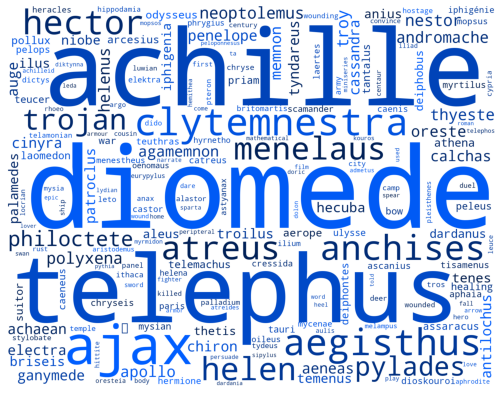


WordCloud for the 4 community


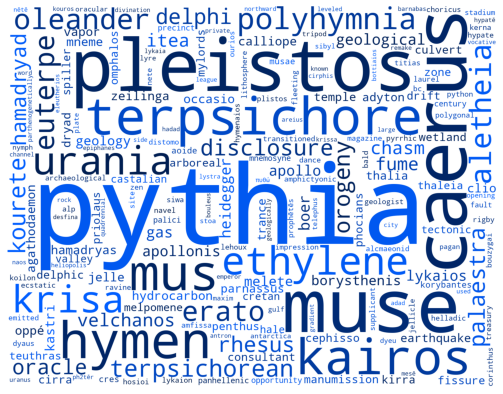


WordCloud for the 5 community


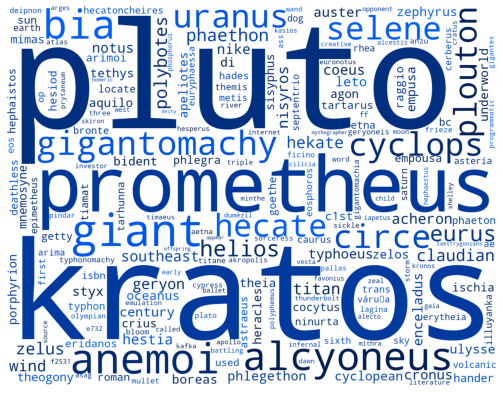


WordCloud for the 6 community


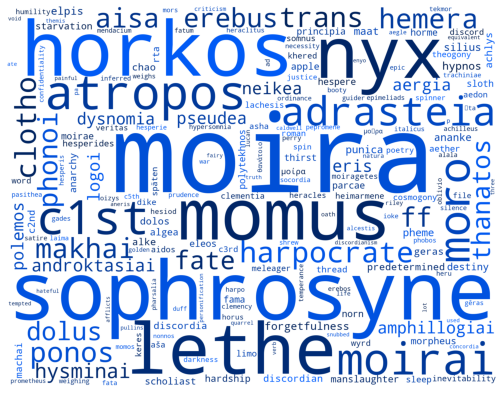


WordCloud for the 7 community


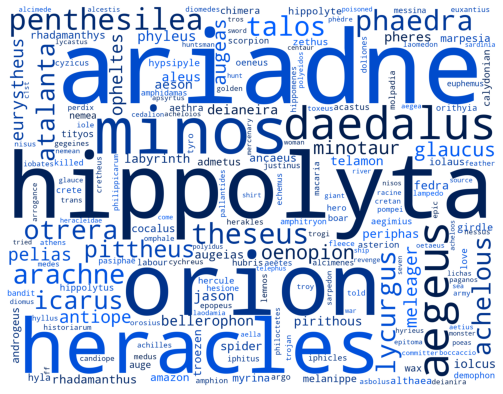


WordCloud for the 8 community


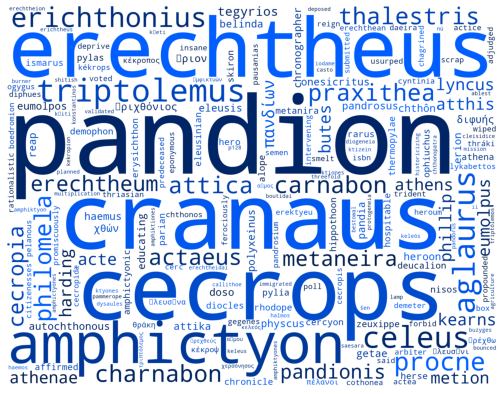


WordCloud for the 9 community


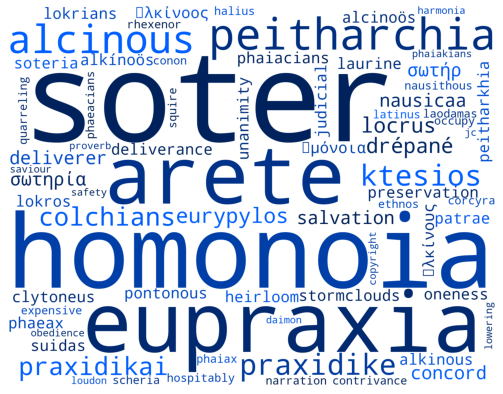

In [44]:
# Create wordclouds for community 0
for i in range(len(tfidf)):
    print("WordCloud for the {} community".format(i))
    plot_wordcloud(tfidf[i], blue_color_func, i+1)
    print("")
    

The WordClouds provide us with a deeper understanding of each community. Some of them cover larger themes such as
community 0, where we figured that many of the Gods were in. Some of the highest scored words, besides names
of Gods, are *Aura*, *Adonis* and *Despoina* being deities and *Pandora* being a mortal. Community 1 confirms our
initial assumptions of it having something to do with the sea. For community 2, it is seen that many of the words
are key characters and terms in the Theban tragedy, *Antigone*. In community 3, we see that many of the terms are
names of characters appearing in the Trojan War. Community 8 consists of words that have something to do with the
king of Athens, i.e. *Pandion*, *Erechtheus*, *Cranaus* and *Cecrops* are all characters that have been kings.

Some of the communities are still not the best partitions. This is something that is expected and ties with the
point explained before, about Greek mythology not really having any clear partitions. Some of the Gods such as
*Zeus*, *Hades* and *Poseidon* interact with all of the characters, thus they do not appear in the WordClouds.

### 3.4. Sentiment scores

In the following chapter we are going to focus on the sentiment scores of each character, as well as the 
communities, which were found based on the Louvain algorithm.
Furthermore, we are also going to examine the sentiment for each character type.
Hence we are going to compare the sentiment analysis done for the found communities and the character types.

As mentioned in section 2, we downloaded both the raw and clean Wikipedia texts for each character.
For the sentiment score analysis for each character the raw text is used, while for the sentiment score analysis of the comunities the clean text is used.

To find the sentiment score, the labMT 1.0 file was used to assign a large selection of words a sentiment score. 
The file was downloaded from the article 
[*Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter*](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752).
Using this file, a dictionary with every word as a key and their sentiment value as each keys value was created.

#### 3.4.1. Sentiment scores for each character
Then, to calculate the sentiment for a Wikipedia page, the `calc_sentiment` function was created.
The function goes through each word in the Wikipedia page and checks if the word is in the dictionary of sentiment words.
When all the words are found, their corresponding sentiment scores are found. 
Then the mean of all these scores are found, which is then returned as the sentiment of a character.

In [45]:
# Read the LabMT text file with happiness scores for words and create a 
# dictionary for the words and their average happiness.
labMT = pd.read_csv('labMT.txt',skiprows=3, sep = '\t')
sents = pd.Series(labMT.happiness_average.values, index=labMT.word).to_dict()

# Function that calculates the happiness of a sentence by finding which
# words appear in the LabMT list and find the average of those words.
def calc_sentiment(tokens):
    filter_tokens = [x for x in tokens if x in sents.keys()]
    sentiments = [sents[i] for i in filter_tokens]
    if sum(sentiments) != 0:
        sentavg = np.mean(sentiments)
        return sentavg
    else:
        return 0

# Add the sentiment as an attribute to each greek character
nodes = Gcc.nodes()
attributes = {}
fold = 'GreekMythologyNetwork/wikipages/raw/'

for n in nodes:
    try:
        name = n
        raw = open(fold + '/' + name + '.txt', 'r', encoding="utf-8")
    except:
        continue
    
    text = raw.read()
    text = text.lower()
    tokens = re.findall(r'\w+', text)
    attributes[n] = {'sentiment': calc_sentiment(tokens)}

nx.set_node_attributes(Gcc, attributes)

Now, a histogram of each characters sentiment score is created:

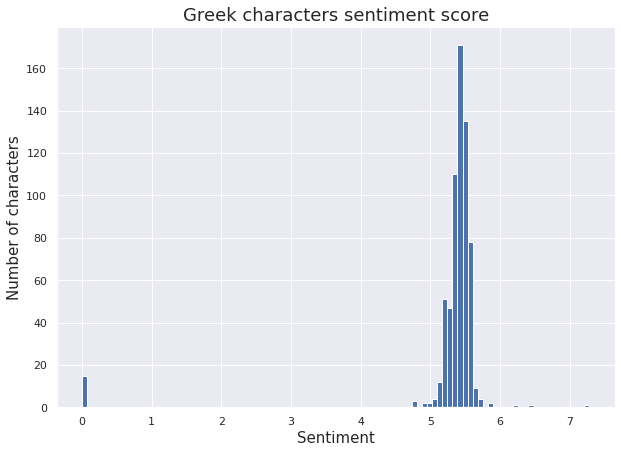

In [48]:
# Find all sentiments
nodes = Gcc.nodes()
sentiment = [nodes[n]['sentiment'] for n in nodes if 'sentiment' in nodes[n].keys()]

# Plot the distribution using matplotlib
plt.figure(figsize=(10, 7))
plt.hist(sentiment, bins = 100)
plt.title('Greek characters sentiment score', size=18)
plt.xlabel('Sentiment', size=15)
plt.ylabel('Number of characters', size=15)
plt.show()

We can see that the sentiment score, is mainly distributed between a score of 5 and 6.
This is possibly due to the way the Wikipedia articles are written, as the content is written in a neutral way.
Wikipedia articles are most of the time written by many different authors, thus it accounts for potential biases
there could be within those articles.
Additionally, there are some outliers with a sentiment score of zero. 
This is due to the fact, that some characters don't include any of words with a sentiment score on their Wikipedia
pages, i.e. the pages just consisting of links to other characters, or the page being redirected to another
character's page.

We find the 10 characters in terms of their highest and lowest sentiment scores, i.e. the happiest and saddest pages:

In [49]:
# Finding the happiest and saddest characters by creating a list of 
# all characters and their sentiments, and sort them by the sentiment
happy_characters = [(n, nodes[n]['sentiment']) for n in nodes if 'sentiment' in nodes[n].keys()]
happy_characters = sorted(happy_characters, key=lambda x: x[-1], reverse=True)

print('10 happiest characters in the Greek Mythology')
for c in happy_characters[:10]:
    print(c[0], c [1])
print()

print('10 saddest characters in the Greek Mythology')
for c in sorted(happy_characters[-10:], key=lambda x: x[-1]):
    print(c[0], c [1])
print()

10 happiest characters in the Greek Mythology
Hymenaios 7.28
Pan 6.42
Car 6.233333333333334
Stilbon 5.8951515151515155
Auxo 5.84
Pyroeis 5.722641509433961
Anthousai 5.717636363636363
Poros 5.706806282722513
Hegemone 5.702325581395349
Zephyrus 5.660434782608696

10 saddest characters in the Greek Mythology
Ogygus 0
Eurus 0
Rhadamanthys 0
Eros (god) 0
Gorgyra 0
Aegaeon 0
Cladeus 0
Deianeira 0
Auxesia 0
Ceisus 0



We want to exclude the zero happiness score characters, as these characters doesn't have any words with a sentiment score on their page.
An example of this is for [Thelxinoe](https://en.wikipedia.org/wiki/Thelxino%C3%AB).

In [50]:
happy_characters_without_zero = [i for i in happy_characters if i[1] != 0]

This yield the following happiest and saddest characters:

In [51]:
# Finding the happiest and saddest characters by creating a list of 
# all characters and their sentiments, and sort them by the sentiment
happy_characters_without_zero = sorted(happy_characters_without_zero, key=lambda x: x[-1], reverse=True)

print('10 happiest characters in the Greek Mythology')
for c in happy_characters_without_zero[:10]:
    print(c[0], c [1])
print()

print('10 saddest characters in the Greek Mythology')
for c in sorted(happy_characters_without_zero[-10:], key=lambda x: x[-1]):
    print(c[0], c [1])
print()

10 happiest characters in the Greek Mythology
Hymenaios 7.28
Pan 6.42
Car 6.233333333333334
Stilbon 5.8951515151515155
Auxo 5.84
Pyroeis 5.722641509433961
Anthousai 5.717636363636363
Poros 5.706806282722513
Hegemone 5.702325581395349
Zephyrus 5.660434782608696

10 saddest characters in the Greek Mythology
Danaë 4.775
Aeëtes 4.775
Thelxinoe 4.775
Harmonia 4.903333333333333
Aetolus 4.94
Palaemon 4.98
Boreas 5.0133333333333345
Dione 5.038888888888889
Alala 5.076328358208956
Ennomus 5.080677966101695



Inspecting the Wikipdia pages of the top 3 happiest and saddest characters, may give some information on why the characters are happy and sad:

##### 3 Happiest characters:
* [Hymenaios](https://en.wikipedia.org/wiki/Hymen_(god)) is the god of the weddings.
* [Pan](https://en.wikipedia.org/wiki/Pan_(god)) is the god of the wild, rustic music and impromptus.
* [Car](https://en.wikipedia.org/wiki/Car_(Greek_myth)) is a name in greek mythology that refers to two characters who may or may not be one and the same.


##### 3 Saddest characters:
* [Danae](https://en.wikipedia.org/wiki/Dana%C3%AB) was an Argive princess and is involved in sad mythologies.
* [Aeëtes](https://en.wikipedia.org/wiki/Ae%C3%ABtes) was a king of Colchis.
* [Thelxinoë](https://en.wikipedia.org/wiki/Thelxino%C3%AB) one of the Sirens 



With this information, the sentiment analysis makes more sense.
The happiest characters are related to more happy topics, such as weddings and music/theatre, 
while the saddest characters often are invovled in tragic stories 
(e.g. the Sirens luring sailors with their music and voices to get them to shipwreck on the rocky coast).

#### 3.4.2. Sentiment scores for each community

We are also interested in finding the happiest and saddest communities. 
Here, the sentiment is defined as the average sentiment for all characters in a community:

In [52]:
# Create a new attribute to each character in Greek Mythology, that indicate
# which community they belong to in the partition.
com_attr = {}

# Creates a new attribute for the nodes, stating which community they belong to
for key, val in partition.items():
    com_attr[key] = {'community': val}

nx.set_node_attributes(Gcc, com_attr)
unique = np.unique(list(partition.values()))

# Finding the average happiness in each community.
com_happiness = {}

for val in unique:
    # Finding all nodes belonging to a community and create a subgraph of those
    com_nodes = (node
                 for node, data
                 in Gcc.nodes(data=True)
                 if data.get("community") == val)
    G_com = Gcc.subgraph(com_nodes)
    
    # Find all sentiment for these community nodes
    nodes = G_com.nodes()
    sentiment = [nodes[n]['sentiment'] for n in nodes if 'sentiment' in nodes[n].keys()]
    
    # Find the most connected characters in the community and name the 
    # community after these.
    most_connected = sorted(dict(G_com.degree()).items(), key = lambda x : x[1], reverse=True)
    most_connected = [x[0] for x in most_connected[:3]]
    community_name = ' '.join(most_connected[:3])
    
    # Create a try statement in case a community doesn't have any happiness
    try:
        happiness = sum(sentiment)/len(sentiment)
        com_happiness[community_name] = round(happiness, 3)
    except:
        pass

Each community is named after the three most connected characters in each community.
As there are 10 communities in total, we show the top five happiest and saddest communities:

In [53]:
# Sort the communities by the happiness and print the most and least happy
# communities
com_happiness_list = sorted(com_happiness.items(), key = lambda x : x[1], reverse=True)

print('Most happy communities')
for com in com_happiness_list[:5]:
    print(com[0], com[1])

print()
print('Least happy communities')
for com in com_happiness_list[-5:]:
    print(com[0], com[1])

Most happy communities
Dionysus Tiresias Cadmus 5.45
Zeus Euterpe Mese 5.43
Soteria Soter Arete 5.396
Oceanus Tethys Uranus 5.283
Heracles Theseus Minos 5.275

Least happy communities
Eris Nyx Erebus 5.27
Apollo Agamemnon Achilles 5.262
Aphrodite Hermes Ares 5.256
Poseidon Naiad Nereus 5.214
Eleusis Thrace Erichthonius 5.146


##### Characters of the happiest communities:
Looking at the top 3 most connected characters in the happiest network (Dionysus, Tiresias, Cadmus), it is found that: 

[**Dionysus**](https://en.wikipedia.org/wiki/Dionysus) 
was the ancient Greek god of wine, winemaking, grape cultivation, fertility, ritual madness, theater, and religious ecstasy.

[**Teiresias**](https://en.wikipedia.org/wiki/Tiresias)
was, perhaps, the most famous of all ancient Greek seers. 
Son of Everes and Chariclo, he lived through seven generations, from the days of Cadmus and all the way to the time of Oedipus and his children. 
He was blinded either by Athena or by Hera for having either seen the first one naked or offended the latter goddess by taking Zeus’ side in a marital argument.

[**Cadmus**](https://en.wikipedia.org/wiki/Cadmus)
was the founder and first king of Thebes in Greek mythology. 
He was the son of King Agenor and Queen Telephassa of the Phoenician city of Tyre, and brother of Phoenix, Cilix and Europa. 
It was believed that he was the person who introduced the Phoenician alphabet to the Greeks, who then adapted it into their own.
 
All three have rather neutral wiki pages, while they have some sort of sad element, whether it be a loss of a loved one or a death involved.
However this is not outstanding, as most greek mythologies have a dramatic or tragic element involved.

##### Characters of the least happy communities:
Now looking at one of the saddest networks (Eris, Nyx, Erebus), it is found that:
 
[**Nyx**](https://en.wikipedia.org/wiki/Nyx)
(Ancient Greek: 'Night') is the Greek goddess (or personification) of the night. 
A shadowy figure, Nyx stood at or near the beginning of creation and mothered other personified deities such as Hypnos (Sleep) and Thanatos (Death), 
with Erebus (Darkness).
  
[**Erebus**](https://en.wikipedia.org/wiki/Erebus) 
(Ancient Greek:"deep darkness, shadow" or "covered"), was often conceived as a primordial deity, representing the personification of darkness. 
For instance, Hesiod's Theogony identifies him as one of the first five beings in existence, born of Chaos.

[**Eris**](https://en.wikipedia.org/wiki/Eris_(mythology)) 
was the Greek goddess of chaos, strife and discord. 
She was the daughter of Zeus and Hera. 
According to other myths, she was the daughter of Nyx (dark night) alone. Her opposite is Harmonia. 
The equivalent Roman goddesses of Eris and Harmonia were Discordia and Concordia. 
She had a son, Strife, whom she brought along with her when she rode her chariot to war alongside Ares.

Here we see that the characters are about sad/darker topics, such as darkness or chaos, strife and discord.
But that doesn't necessarily mean that these topics reflect a sad story, as the score for the community still is above 5. 

#### 3.4.3. Comparing the communities to communities based on their type

Now we want to analyze the different character groups (i.e. Gods, Deities, etc.), 
as it would be intersting to see how sentiment compares to the communities found by the Louvain algorithm.
First we examine the size of each character group:

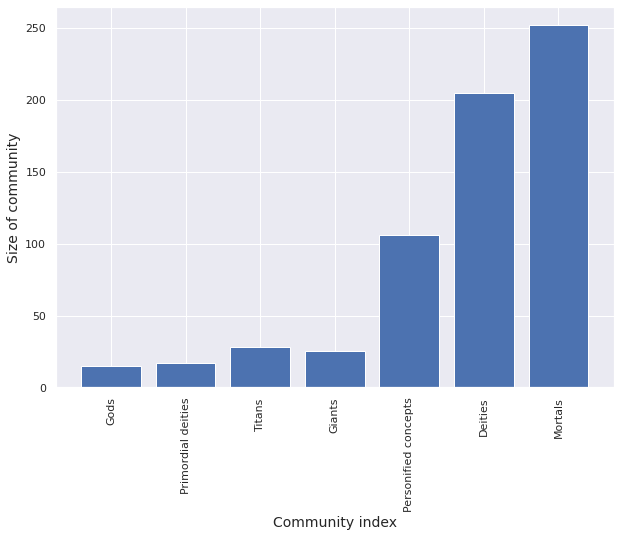

In [54]:
# Define a dictionary of community types
communities_types = {
    "Gods": [],
    "Primordial deities": [],
    "Titans": [],
    "Giants": [],
    "Personified concepts": [],
    "Deities": [],
    "Mortals": []
    }

# Append characters within each type to to communities_types
for i in Gcc.nodes():
    feature = Gcc.nodes()[i]['type']
    communities_types[feature].append(i)

# Find the size of each community
com_size = [len(communities_types[key]) for key in communities_types.keys()]

# Plot the distribution of community sizes
plt.figure(figsize=(10,7))
plt.bar(communities_types.keys(), com_size)
plt.xlabel('Community index', size=14)
plt.xticks(rotation=90)
plt.xticks(range(7))
plt.ylabel('Size of community', size=14)
plt.show()

It's seen that the *Mortals* group is the largest and the *Primordial deities*, *Giants*, *Gods*, and *Titans* are the smallest groups. 
Additionally, while comparing the groups to the communitites found through the Louvain algorithm, 
it's observed that the communities and groups differ in terms of their size.
The communitites have a simiar size/amount of characters, which is opposite to the groups.

Now the sentiment scores are found for the groups. 
Like for the communities, the sentiment score is defined as the average sentiment of all characters in a group:

In [55]:
# Finding the average happiness in each community.
com_happiness_type = {}

for val in communities_types:
    # Finding all nodes belonging to a community and create a subgraph of those
    com_nodes = (node
                 for node, data
                 in Gcc.nodes(data=True)
                 if data.get("type") == val)
    G_com = Gcc.subgraph(com_nodes)
    # Find all sentiment for these community nodes
    nodes = G_com.nodes()
    sentiment = [nodes[n]['sentiment'] for n in nodes if 'sentiment' in nodes[n].keys()]
    
    community_name = val
    
    # Create a try statement in case a community doesn't have any happiness
    try:
        happiness = sum(sentiment)/len(sentiment)
        com_happiness_type[community_name] = round(happiness, 3)
    except:
        pass

# Sort the communities by the happiness and print the most and least happy
# communities
com_happiness_list_type = sorted(com_happiness_type.items(), key = lambda x : x[1], reverse=True)

print('Most happy communities')
for com in com_happiness_list_type[:3]:
    print(com[0] + ':', com[1])

print()
print('Least happy communities')
for com in com_happiness_list_type[3:]:
    print(com[0] + ':', com[1])

Most happy communities
Gods: 5.432
Titans: 5.421
Giants: 5.395

Least happy communities
Deities: 5.334
Personified concepts: 5.291
Mortals: 5.24
Primordial deities: 5.054


Here it's seen that *Titans, Giants, Gods* are the three happiest groups, 
while *Primordial deities, Mortals, Personified concepts* are the three least happy groups.
Deities are inbetween these six groups.

However, the sentiment score for the different groups don't differ widely. 
The difference between the happiest group and the saddest group is 0.4 in sentiment score.
This is probably the result of the Wikipedia pages being written neutrally, as mentioned before.

## 4. Discussion
### What went well?
We were able to analyze our data on based on the characters and attributes that Wikipedia provided. In the beginning,
we were doubting that the specific API that we used wasn't good for analysis, yielding some rather random outcomes.
We were considering switching to the [wikia.org page](https://greekmythology.wikia.org/wiki/Greek_Mythology_Wiki), 
which also contains a lot of information about each character. But after looking through some of the pages, we
stuck to our original idea, as some did not contain the information, we wanted. It turned out not to be a problem
during our analysis either, as we managed to get meaningful conclusions from our chosen API.

Our initial list of characters within each type struck some doubt that we were unable to sort each character within
each type. We put down the necessary time for extracting unique characters using RegEx and deleting the multiple
appearances of some characters that were present.

For finding communities, we used the Louvain algorithm, where many of the communities made more sense than
what we initially thought. Some of the communities clearly had something to do with Poseidon, water nymphs and the
sea, where others were characters with specific connections to the trojan war. Furthermore, none of the found
communities appeared to be small as one might have expected. 
There is somewhat of a correspondence between the communities found by the Louvain algorithm and those classified by their types. 
The characters belonging to each community are similar, e.g. community 0 consists of a large portion of the Gods, 
while community 8 consists of many mortals

It is also seen that the network is not random - it follows a power law, both in terms of in- and out-degree.
This allows us to try and look at different hubs, where the main conclusion is that the hubs are the Gods. This
makes sense as they have an appearance through the vast majority of the written myths and stories, thus many of the
remaining characters have clear connections to them. Some other hubs include significant characters such as Heracles.

Besides the analysis, setting up the website for our network has been fun to work with. It taught us
to show our findings in a way that is presentable to an audience, who might not have worked with network analysis
before. Some of the tools that we put up on the website also helped us with the understanding of our network,
especially the interactive plotting of our network. 

At last, we have worked well as a team and supported each other. As a team, we managed to delegate our tasks and meet
up at the university to get our work done. During our work with the project, we managed to get a deeper understanding 
of both network analysis but also Greek mythology. This especially happened when finding how each of the communities
made sense, along with writing our findings in a way for an audience to understand, thus we have gained extensive 
knowledge about our chosen topic.

### What is still missing? What could be improved? Why?
We have used the Wikipedia API. However as we observe from the assignments as well as from our project we can see
that Wikipedia is a neutral page, based on the evidence that we obtain similar sentiment scores for all characters 
and communities. However we would have expected the Greek Mythology characters to be highly different in terms of
their sentiment scores, because the myths often are very sentimental and discovers backgrounds and emotions that
are highly exaggerated.

For the sentiment analysis of the characters, we are using raw data because the clean data creates characters 
with a sentiment score of 0, because they dont have their own text. The text on these pages are mainly
references to other characters or introduction text.

The communities that we detected and the communities in terms of their attributes did not reach a very high
modularity. As mentioned beforehand, this could be caused by not having very clear partitions and groups in
Greek mythology, as there are with e.g. superheroes (Marvel's X-Men) or the Harry Potter network (the houses).
The partitions that we could find were in terms of their types, but as many of the Gods
interact with deities, mortals etc. very frequently, it would be difficult to classify them as a community in
itself.

We could have chosen to look at a different type of attribute. An idea would be to get inspired by the Marvel
and DC universe and add the Roman mythology network. It would be interesting to see how the two networks
are similar, as we know that there are some characters with similar traits and attributes. Some characters are
even direct parallels.

One of the goals in the beginning was to find the most dramatic characters, which has not been completed in this
assignment. One of the reasons for this is that we had a hard time defining what drama is. Drama could be words
and general themes such as love and hate, but drama also has a lot to do with contexts from litterature and how
the individual author creates more excitement and tension within a text. We also had a difficult time finding
dramatic words on the Internet with assigned scores in the same way as sentiment scores is in terms of happiness.
A way of potentially solving this is to do further analysis, looking into different words ourselves and
analyzing the actual texts within Greek mythology, and not just Wikipedia pages, that are neutral and factual,
generally not having much drama in them.


## 5. Contributions. Who did what?

For our project, Stefan has mainly worked on setting up the webpage.
Jan and Enny have worked on the explainer notebook.